# Análisis
Se cargan modulos y paquetes y se realiza el tratamiento de datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import sys
sys.path.insert(0,'../utils')

import constants as cons
import funciones as funtils

df_gamepass = pd.read_csv(cons.DF_GAMEPASS_SRC)
df_gamepass = df_gamepass.drop(columns=[cons.RATIO, cons.TRUE_ACHIVEMENTS, cons.GAME_SCORE])
df_gamepass[cons.GAMERS] = pd.to_numeric(df_gamepass[cons.GAMERS].str.replace(',', ''), errors='coerce')
df_gamepass = df_gamepass[df_gamepass[cons.GAMERS] != 0]
df_gamepass[cons.TIME] = df_gamepass[cons.TIME].apply(funtils.calculate_mean_time)

df_metacritic = pd.read_csv(cons.DF_METACRITIC_SRC)
df_metacritic = df_metacritic.drop(columns=[cons.ID, cons.PLATFORM, cons.SORT_NO, cons.SUMMARY])

df_metacritic[cons.TITLE] = df_metacritic[cons.TITLE].str.lower()
df_gamepass[cons.GAME] = df_gamepass[cons.GAME].str.lower()
df_merged = pd.merge(df_metacritic, df_gamepass, left_on='title', right_on=cons.GAME, how='inner')
df_merged = df_merged.drop_duplicates()
df_merged = df_merged.sort_values(by=[cons.USER_SCORE, cons.COMP, cons.METASCORE], ascending=False).drop_duplicates(subset=cons.TITLE, keep='first')

df_merged = df_merged[df_merged[cons.GAMERS] >= 1000]
median_time = df_merged[cons.TIME].median()
df_merged[cons.TIME].fillna(median_time, inplace=True)

df_merged = df_merged.drop(columns=[cons.ADDED, cons.RELEASE_DATE, cons.GAME])
df_merged[cons.USER_SCORE] = df_merged[cons.USER_SCORE].apply(lambda x: 0 if not x.replace('.', '', 1).isdigit() else x)
df_merged[cons.USER_SCORE] = pd.to_numeric(df_merged[cons.USER_SCORE])

df_merged.rename(columns={cons.RATING: cons.XBOX, cons.USER_SCORE: cons.METACRITIC_USER_SCORE}, inplace=True)

df_merged['xbox_user_score'] = df_merged['xbox_user_score'] * 20
df_merged['metacritic_user_score'] = df_merged['metacritic_user_score'] * 10
df_merged['metascore'] = df_merged['metascore'].astype(float)
df_merged.reset_index(drop=True, inplace=True)

C:\Users\PC ELITE\AppData\Local\Temp\ipykernel_14676\405281405.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[cons.TIME].fillna(median_time, inplace=True)


Listo, ahora se continua desde donde lo dejamos

Para una mejor comprensión de cada variable, la siguiente tabla detalla de que va cada una
| Columna/Variable       | Descripción                                                                                                                                                               | Tipo       | Importancia | Nota                                                                                                                          |
|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|-------------|------------------------------------------------------------------------------------------------------------------------------|
| metascore              | Indica la valoración dada por los críticos avalados por Metacritic de cada título                                                                                        | Numérica   | Alta        | Nos ayuda a saber el veredicto de los "expertos".                                                                            |
| title                  | Nombre de cada videojuego                                                                                                                                                 | Categórica | Media       | Ayuda a identificar el nombre del juego, pero en este análisis damos más peso a sus valoraciones.                           |
| metacritic_user_score  | Valoración por los usuarios/jugadores suscritos en Metacritic, pero que no tienen ese "plus" de ser críticos avalados por la plataforma                                   | Numérica   | Alta        | Aunque hay expertos que dan valoraciones a los videojuegos, la comunidad también tiene voz y peso en sus opiniones.          |
| GAMERS                 | Número de jugadores que han jugado el título                                                                                                                              | Numérica   | Alta        | Con el número de jugadores podemos determinar el impacto que tuvo el título desde que se añadió al catálogo.                 |
| COMP %                 | Porcentaje de jugadores que han completado el título                                                                                                                     | Numérica   | Alta        | Nos ayuda a saber cuántos jugadores han aprovechado el servicio para completar los títulos en el catálogo.                   |
| TIME                   | Tiempo medio para completar el título                                                                                                                                     | Numérica   | Media       | Puede ayudarnos a saber cuánto tiempo tarda un jugador en promedio para completar el título y analizar si es un factor clave. |
| xbox_user_score        | Calificación del título dada por usuarios de Xbox                                                                                                                         | Numérica   | Media       | Aunque es una valoración dada por usuarios de Xbox, no nos da mucha certeza, ya que se restringe a usuarios de esta plataforma y son pocas las calificaciones.      |


## Análisis univariante

Empezamos haciendo un análisis univariante de cada variable numérica (ya que son las que nos interesan en ese estudio)

In [2]:
# Análisis univariante de variables numéricas en df_merged
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns

# Estadísticas descriptivas
df_merged[numeric_columns].describe()


,metascore,metacritic_user_score,GAMERS,COMP %,TIME,xbox_user_score
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,78.437853,70.988701,93647.059322,6.007627,50.430791,75.870056
std,8.693577,16.304291,93057.468284,10.128412,59.118143,8.975576
min,43.000000,0.000000,1065.000000,0.000000,1.500000,44.000000
25%,73.000000,67.000000,23690.250000,0.600000,13.500000,70.000000
50%,79.500000,75.000000,62594.500000,1.900000,27.500000,76.000000
75%,84.750000,81.000000,131071.500000,6.100000,70.000000,82.000000
max,96.000000,96.000000,455839.000000,62.900000,400.000000,96.000000


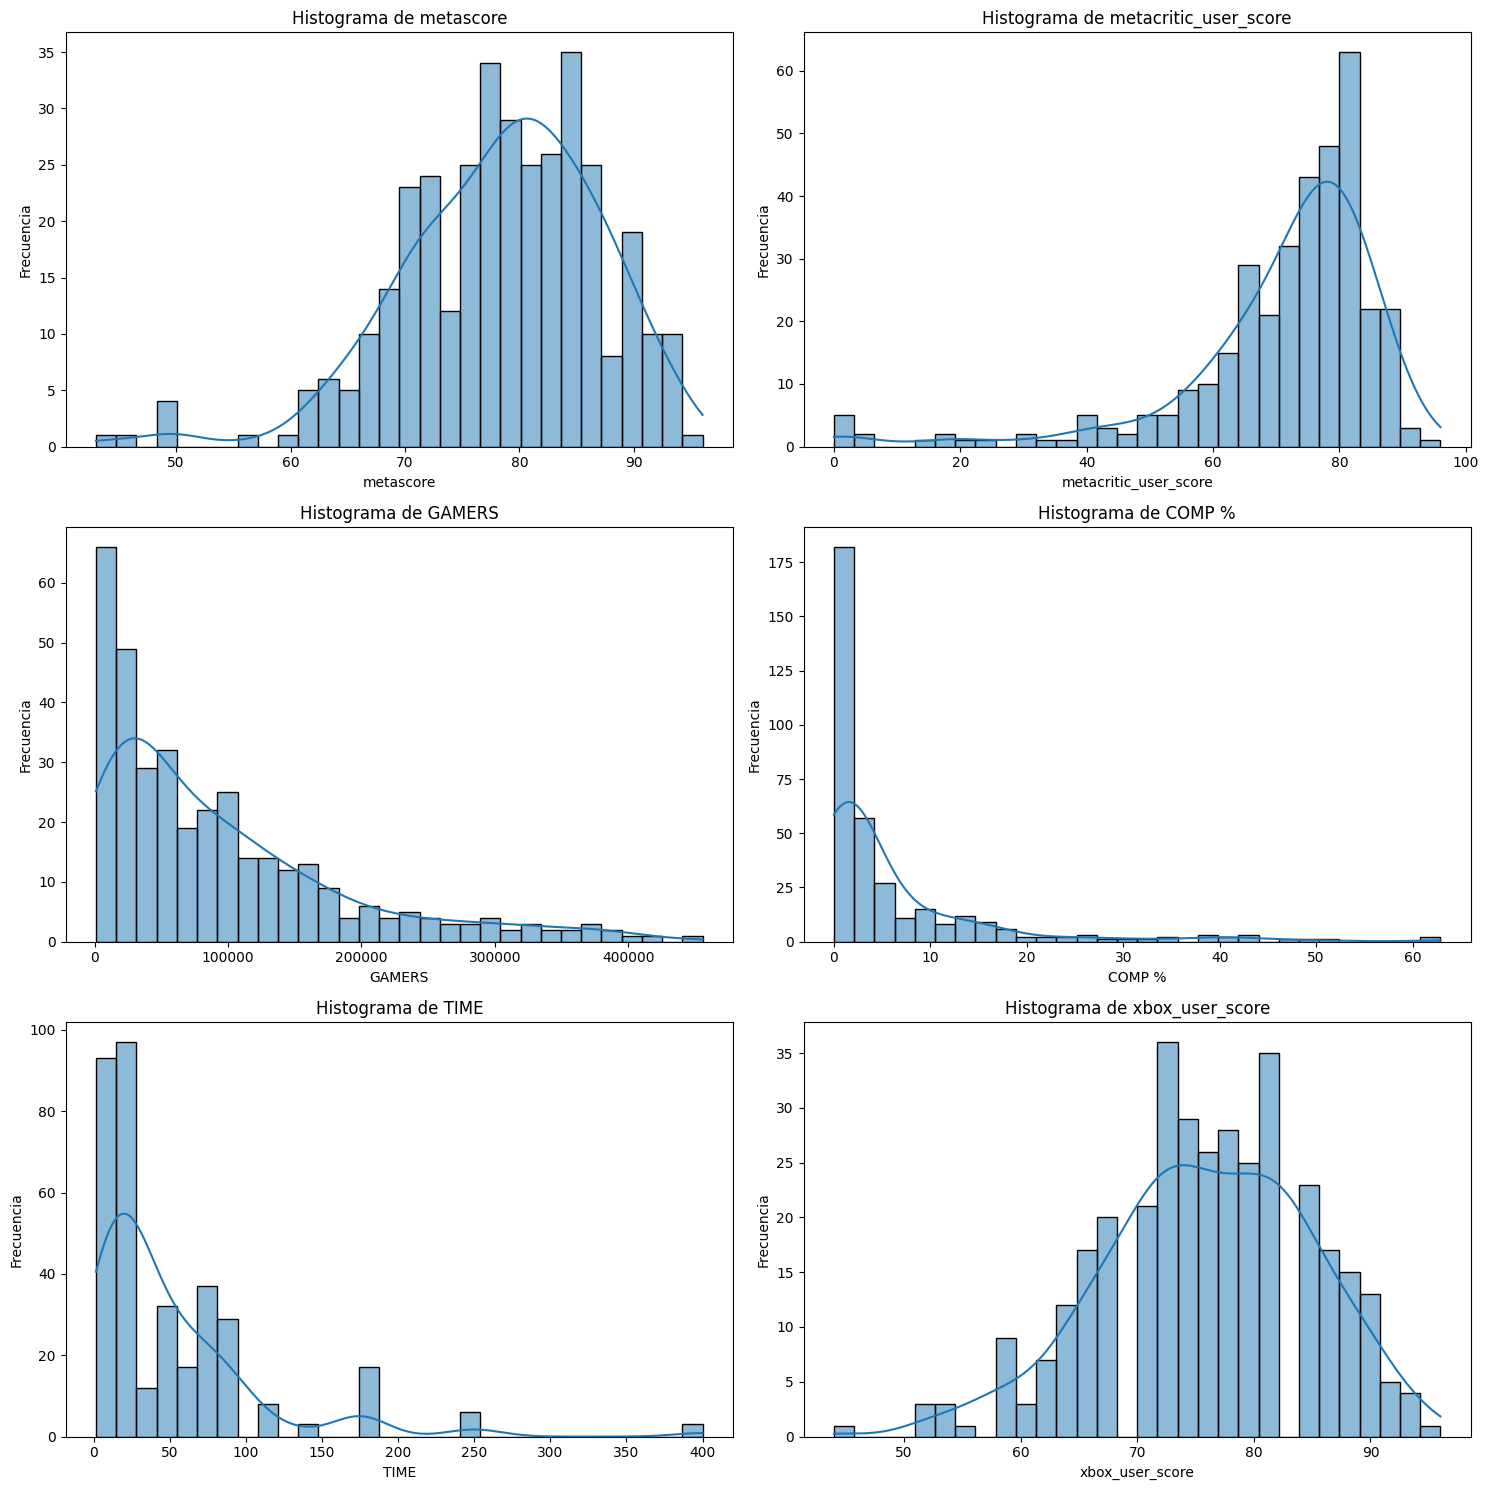

In [3]:
funtils.plot_numerical_histograms(df_merged, numeric_columns, bins_list=[30,30,30,30,30,30], kde=True)

Revisando las gráficas, se pueden tener unas primeras conclusiones:
* En su debida proporción, las valoraciones dadas por criticos de Metacritic, usuarios de Metacritic y usuarios de Xbox en el valor máximo pero los estadísticos de las valoraciones de críticos de Metacritic y usuarios de Xbox se parecen mucho más.
* Como se vió anttes, hay juegos que durán alrededor de 30 horas en su mayoría.
* Después de hacer el corte de número de jugadores en cada juego, se tiene una media significativa de alrededor de 100,000 jugadores
* Hay bastantes juegos que no han sido completados, ni siquiera llevan un 10% de completado. Habría que analizar que valoraciones tienen esos juegos.